# Milestone 3

Research Question: Is there a representation in Wikipedia about countries?
Additional research question: What does the behaviour of the player tell us about their cultural knowledge about countries?

The notebook is structured in the following way:
- Loading data
- Data wrangling
- Data analysis for the research sub-questions (articles = Wikipedia article of a country)
    - Part 1: descriptive statistics of the Wikispeedia DataSet
        * Q1: How different are the length of the articles and their number of hyperlinks?
        * Q2: How positive or negative is the content of an article?
    - Part 2: descriptive statistics about the behaviour of the players using articles about countries
        * Q3: How different is the ratio of finished pathways, where a country is the start/target?
        * Q4: How different is the length of the pathway taken respectively the time needed, where a country is the start/target?
        * Q5: How often does an article appear in a pathway where it is neither the start nor the traget?
    - Part 3: Analysis of biases
        * Q6: Establish baseline (e.g. expected length for world mean population or economic strength)
        * Q7: By investigating article length, article sentiment or number of hyperlinks while controlling for e.g. population size, economic power or if English is an official language, is there a representation bias based on countries in Wikipedia?  
        * Q8: While controlling for as much of the bias in the dataset as we can, do we see additional bias of the players in the pathways they have taken? -> culutral bias (how much do players know about countries, since we can not conclude anything without demographic informations about the players)
    
    To compare all countries (more than 200) would be too confusing, therefore they are grouped by region, economic developement and population to plot the graphs.

In [1]:
# Loading all the necessary packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from urllib.parse import unquote
import seaborn as sns
import networkx as nx
#import plotly.express as px
#import plotly.graph_objects as go
import statsmodels.formula.api as smf
import scipy.stats as stats
from urllib.parse import unquote

# import helper functions from python script
import helper as hlp
import sentiment_analysis as sa

## Loading & cleaning data

In [40]:
articles =  pd.read_csv("data/wikispeedia_paths-and-graph/articles.tsv", sep='\t', names=["article"], skiprows=12)
links = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv("data/wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt("data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt", dtype=str, comments="#", unpack=False)
categories= pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', names=["article", "category"], skiprows = 13)

# seperate each row and create a matrix with all the shortest distance
table_distance = np.array([[int(c) if c != '_' else -1 for c in row] for row in shortest_distance_text])

UN_countries = pd.read_csv("data/UNSD — Methodology.csv", delimiter = ';')
UN_countries_by_economies_load = pd.read_csv("data/countries_by_income_category.csv")
UN_countries_by_economies_load.columns = ['Country or Area', 'Economic classification']

# Translating all article titles to user readable format
articles['article'] = articles['article'].apply(unquote)
links['link_source'] = links['link_source'].apply(unquote)
links['link_target'] = links['link_target'].apply(unquote)
paths_finished['path'] = paths_finished['path'].apply(unquote)
paths_unfinished['path'] = paths_unfinished['path'].apply(unquote)
paths_unfinished['target'] = paths_unfinished['target'].apply(unquote)
categories['article'] = categories['article'].apply(unquote)

## Data wrangling 
The imported data is cleaned and put into  different pd.DataFrames which we will need for the analysis.

1. path_overview: combiens information about all the path of all games played (unfinished and finished)
2. main_categories: dataframe that contains the main category of all Wikipedia articles
3. df_country_regions: dataframe that contains the region a country belongs to
4. UN_countries_by_economies: contains economic classifications per country
5. plaintext_articles: contains the whole content of Wikipedia articles about countries
6. sentiment_analysis_of_countries: contains results from sentiment analysis of countries Wikipedia article



-> Create path_overview DataFrame


In [3]:
# expand the finished paths
path_fin = paths_finished.copy()
path_fin = path_fin.assign(source=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                           target=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                           game_path=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                           completed=True)

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin = path_ufin.assign(source=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                             failure_article=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                             game_path=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished["target"])

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                     "durationInSec", "game_path",
                                                                     "completed", "rating","type"]]

articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
# Create a copy of the 'path_overview' DataFrame to avoid modifying the original
path_overview_copy = path_overview.copy()

# Apply the find_path_distance function to each row
path_overview_copy['shortest_distance'] = path_overview_copy.apply(
    lambda row: hlp.find_path_distance(row['source'], row['target'], help_articles, table_distance), axis=1
)

# Update the original 'path_overview' DataFrame with the new 'shortest_distance' column
path_overview['shortest_distance'] = path_overview_copy['shortest_distance']

#remove all rows where the source or target article is not among the available articles in the dataset
path_overview = path_overview.drop(path_overview[~(path_overview['source'].isin(articles['article'].array))].index)
path_overview = path_overview.drop(path_overview[~(path_overview['target'].isin(articles['article'].array))].index)

# remove all rows where there is no path between the source article and target article
path_overview = path_overview.drop(path_overview[path_overview['shortest_distance'] == -1].index) 
path_overview.insert(4, 'shortest_distance', path_overview.pop('shortest_distance'))

# Translating article names from URL to latin characters
path_overview['source'].apply(unquote)
path_overview['target'].apply(unquote)

display(path_overview)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type
0,14th_century,African_slave_trade,6a3701d319fc3754,1297740409,3.0,166,8,True,NaN,NaN
1,14th_century,African_slave_trade,3824310e536af032,1344753412,3.0,88,4,True,3.0,NaN
2,14th_century,African_slave_trade,415612e93584d30e,1349298640,3.0,138,7,True,NaN,NaN
3,14th_century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN
4,14th_century,John_F._Kennedy,015245d773376aab,1366730828,3.0,175,6,True,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
76188,Franz_Kafka,Cholera,109ed71f571d86e9,1389787605,3.0,180,7,False,NaN,restart
76189,Modern_history,Hollandic,232f992e57d43e8d,1389787697,3.0,6,0,False,NaN,restart
76190,Computer_programming,The_Beatles,2e09a7224600a7cd,1389798400,3.0,1900,4,False,NaN,timeout
76191,Jamaica,Alan_Turing,60af9e2138051b96,1389799481,3.0,1903,3,False,NaN,timeout


-> Create main_categories DataFrame

In [4]:
# Apply the custom function hlp.extract_subject_category() to create a new 'subject_category' column
categories['subject_category'] = categories['category'].apply(hlp.extract_subject_category)

# Create a dataFrame with only the relevant columns
main_categories = categories[['article', 'subject_category']]

# Display the new DataFrame
main_categories.head()

,article,subject_category
0,Áedán_mac_Gabráin,History
1,Áedán_mac_Gabráin,People
2,Åland,Countries
3,Åland,Geography
4,Édouard_Manet,People


-> Create df_country_regions dataframe

In [66]:
# Below we find the articles which have different names to those outlined in the UN dataset. We then manually found the corresponding name in the UN
# dataset and created a dictionary to map article names -> UN dataset name

countries = main_categories[main_categories['subject_category'] == 'Countries']['article'].values
countries = [cntry.replace('_',' ') for cntry in countries]

# United Arab Emirates Problem -> Abu Dhabi / Dubai are not countries etc. If confusion, the country with biggest population is kept
countries_to_remove = ['Abu Dhabi', 'Dubai', 'Easter Island', 'Galápagos Islands', 'Korea', 'Abkhazia', 'Republic of China']
countries = [cntry for cntry in countries if cntry not in countries_to_remove]

countries_missing = []

for country in countries:
    country = country.replace('_',' ')
    if country not in UN_countries['Country or Area'].values:
        countries_missing.append(country)

# "China Problem" we keep Taiwan  -> Taiwan, Republic of China -> deleted (same as Taiwan),
# Tibet -> Tibet, People's Republic of China -> China

replacement_country_names = [
    'Åland Islands', 'Ireland', 'Bolivia (Plurinational State of)',
    'Brunei Darussalam', 'Côte d’Ivoire', 'Cabo Verde', 'Czechia',
    'Timor-Leste', 'Falkland Islands (Malvinas)', 'Micronesia (Federated States of)',
    'State of Palestine', 'Georgia', 'China, Hong Kong Special Administrative Region',
    'Iran (Islamic Republic of)', '', 'Lao People\'s Democratic Republic', 
    'Republic of Moldova', 'Netherlands (Kingdom of the)', 'Sint Maarten (Dutch part)', 
    'Democratic People\'s Republic of Korea', 'State of Palestine', 'China', 'Ireland',
    'North Macedonia', 'Russian Federation', 'Sao Tome and Principe', 'Serbia', 'Republic of Korea',
    "", 'Eswatini', 'Syrian Arab Republic', 'United Republic of Tanzania', 'Bahamas',
    'Gambia', 'Tibet', 'Türkiye', 'Turkish Republic of Northern Cyprus', 'United Kingdom of Great Britain and Northern Ireland',
    'United States of America', 'Holy See', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'State of Palestine'
]

replacement_countries = dict(zip(countries_missing, replacement_country_names))

# Creating a dictionary to map each country to its continent (region).
country_to_region = {}

for country in countries:
    country_to_region[country] = hlp.get_region(country, UN_countries, replacement_countries)

# Add manually countries that are not present in the UN dataframe
country_to_region['Kosovo'] = 'Eastern Europe'
country_to_region['South Ossetia'] = 'Western Asia'
country_to_region['Tibet'] = "Central Asia"
country_to_region['Turkish Republic of Northern Cyprus'] = "Southern Europe"	


df_country_region = pd.DataFrame.from_dict(country_to_region, 
                                           orient='index',
                                           dtype=None,
                                           columns=['region'])

df_country_region.reset_index(inplace=True)
df_country_region.rename(columns={"index": "article"}, inplace=True)

# Rename Latin America and the Caribbean to Latin America
df_country_region['region'] = df_country_region['region'].replace('Latin America and the Caribbean', 'Latin America')
df_country_region.columns = ['Country', 'Region']
display(df_country_region)

,Country,Region
0,Åland,Northern Europe
1,Éire,Northern Europe
2,Afghanistan,Southern Asia
3,Albania,Southern Europe
4,Algeria,Northern Africa
...,...,...
217,West Bank,Western Asia
218,Western Sahara,Northern Africa
219,Yemen,Western Asia
220,Zambia,Sub-Saharan Africa


-> UN_countries_by_economies

In [67]:
# hard coded changes in country names that can't be read properly from the .csv file
read_csv_names = ['Turkiye', 'China Hong Kong Special Administrative Region', 'Cote d Ivoire']
new_names = ["Türkiye", "China, Hong Kong Special Administrative Region", "Côte d’Ivoire"]
UN_to_modify = UN_countries_by_economies_load.copy()
for i in range(len(read_csv_names)-1):
    country_index = np.where(UN_countries_by_economies_load['Country or Area']==read_csv_names[i])[0][0]
    UN_to_modify.at[country_index, 'Country or Area'] = new_names[i]

UN_countries_by_economies = pd.merge(UN_countries, UN_to_modify, how='left', on='Country or Area')[['Country or Area', 'Least Developed Countries (LDC)', 'Land Locked Developing Countries (LLDC)', 'Small Island Developing States (SIDS)', 'Economic classification']]
# Show countries that are missing an economic classification (should be 248-163=85)
# missing_countries = UN_countries_by_economies[UN_countries_by_economies['Economic classification'].isna()]['Country or Area'].values

# Rename Countries to match the names of English Wikipedia
replacement_countries_OLD_NEW = dict([(value, key) for key, value in replacement_countries.items()])
UN_countries_by_economies['Country or Area'] = UN_countries_by_economies['Country or Area'].map(replacement_countries_OLD_NEW).fillna(UN_countries_by_economies['Country or Area'])
UN_countries_by_economies = UN_countries_by_economies.sort_values('Country or Area').reset_index(drop=True)

# Check if everything went fine
display(UN_countries_by_economies)

,Country or Area,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Economic classification
0,Afghanistan,x,x,NaN,NaN
1,Albania,NaN,NaN,NaN,Upper middle income
2,Algeria,NaN,NaN,NaN,Upper middle income
3,American Samoa,NaN,NaN,x,NaN
4,Andorra,NaN,NaN,NaN,NaN
...,...,...,...,...,...
244,Western Sahara,NaN,NaN,NaN,NaN
245,Yemen,x,NaN,NaN,Lower middle income
246,Zambia,x,x,NaN,Lower middle income
247,Zimbabwe,NaN,x,NaN,Low-income


-> plaintext_articles

In [68]:
# Create np.array with name of all articles that are about a country
countries = main_categories[main_categories['subject_category'] == 'Countries']['article'].values

# Directory where the .txt files are stored
directory = "data/plaintext_articles/" 

# Initialize an empty list to store the data
data = []

# Iterate over all countries
for country in countries:
    file_path = directory + country + '.txt'

# Open the file and read its content into a string
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            load_file_content = file.read()
            file_content = load_file_content[15:].replace("\n\n2007 Schools Wikipedia Selection", "")

    # Add filname, content and article length to the data list
        data.append((country, file_content, len(file_content)))

# Create a DataFrame from the data list
plaintext_articles = pd.DataFrame(data, columns=['Country', 'Article content', 'Article length'])

# Display the DataFrame
display(plaintext_articles)

,Country,Article content,Article length
0,Abkhazia,Abkhazia. Related subjects: Asian Countries;\n...,33592
1,Abu_Dhabi,Abu Dhabi. Related subjects: Countries; Middle...,12072
2,Afghanistan,Afghanistan. Related subjects: Asian Countries...,40240
3,Albania,Albania. Related subjects: Countries; European...,24203
4,Algeria,Algeria. Related subjects: African Countries;\...,34081
...,...,...,...
215,West_Bank,West Bank. Related subjects: Countries; Middle...,38456
216,Western_Sahara,Western Sahara. Related subjects: African Coun...,25959
217,Yemen,Yemen. Related subjects: Countries; Middle Eas...,28075
218,Zambia,Zambia. Related subjects: African Countries;\n...,31103


-> sentiment_analysis_of_countries

In [69]:
sentiment_analysis_of_countries_load =  pd.read_csv("data/sentiment_analysis.csv")
sentiment_analysis_of_countries=sentiment_analysis_of_countries_load.drop('Unnamed: 0', axis='columns')
display(sentiment_analysis_of_countries)

,Country,Sentiment,NEG_count,NEG_sum,NEU_count,NEU_sum,POS_count,POS_sum
0,Abkhazia,NEU,23.0,16.881333,109.0,98.443426,2.0,1.381859
1,Abu_Dhabi,NEU,4.0,3.016167,42.0,37.855860,3.0,1.977438
2,Afghanistan,NEU,27.0,22.140542,119.0,106.641921,15.0,11.823924
3,Albania,NEU,11.0,8.994323,78.0,67.856187,8.0,5.589544
4,Algeria,NEU,16.0,13.254207,111.0,97.182142,9.0,7.147486
...,...,...,...,...,...,...,...,...
215,West_Bank,NEU,15.0,11.718062,135.0,121.900878,4.0,2.384537
216,Western_Sahara,NEU,24.0,18.424562,79.0,70.846074,1.0,0.630308
217,Yemen,NEU,7.0,5.260394,102.0,91.418999,3.0,2.053402
218,Zambia,NEU,18.0,14.538703,104.0,94.602926,2.0,1.539113


## Data analysis - Part 1:
Descriptive statistics and and naive analysis about the Wikispeedia DataSet

1. Introductory analysis


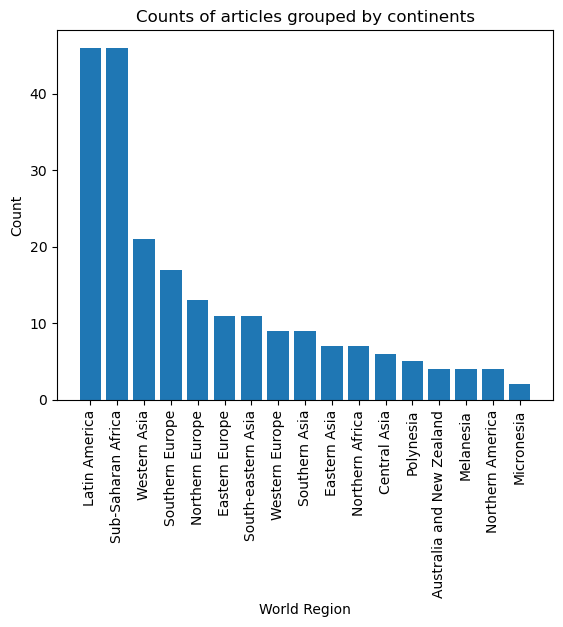

In [72]:
# Plotting the distribution of countries in the dataset based on their continent, which we will consider their region.
countries_per_region = ((df_country_region.groupby('Region').count()).reset_index()).sort_values(by='Country', ascending=False)

plt.bar(countries_per_region['Region'], countries_per_region['Country'])
plt.xticks(rotation=90)
plt.title("Counts of articles grouped by continents")
plt.xlabel("World Region")
plt.ylabel("Count")
plt.show()

# All countries (and a some more) that are recognized by the UN are included in our Dataset.

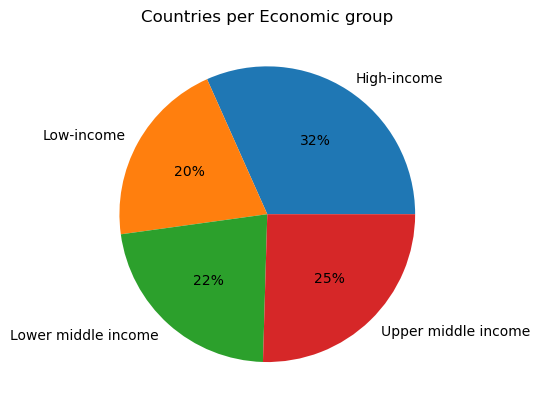

In [73]:
# Plotting the distribution of countries in the dataset based on their continent, which we will consider their region.
countries_per_economie = (UN_countries_by_economies.groupby('Economic classification').count()).reset_index()
countries_per_economie.columns = ['Economic_classification', 'Country','Least Developed Countries (LDC)',
                                    'Land Locked Developing Countries (LLDC)','Small Island Developing States (SIDS)']
total_countries = countries_per_economie['Country'].sum()
countries_per_economie['percentage'] = countries_per_economie.apply(lambda row: row.Country / total_countries * 100, axis=1)

plt.pie(countries_per_economie['percentage'], labels=countries_per_economie['Economic_classification'], autopct='%1.f%%')
plt.title("Countries per Economic group")
plt.show()

## First research questions
We focus on the Wikipedia articles about countries and their hyperlink structure in the Wikispeedia dataset.
### Summary statistics for the number of in- and out- degrees of each region 

In [58]:
links_outdegree = links.copy()
links_outdegree.columns = ['article','link_out']
out_degrees = links_outdegree.groupby('article').count()
out_degrees.sort_values(by='link_out', ascending=False, inplace=True)

links_indegree = links.copy()
links_indegree.columns = ['link_in','article']
in_degrees = links_indegree.groupby('article').count()
in_degrees.sort_values(by='link_in', ascending=False, inplace=True)

link_counts = out_degrees.merge(in_degrees, how='outer', on='article')

In [59]:
country_links = link_counts[link_counts.index.isin(countries)]
country_links.reset_index(inplace=True)
country_links = country_links.merge(df_country_region, on='article', how='left')
country_links.head()

,article,link_out,link_in,region
0,United_States,294.0,1551.0,NaN
1,Lebanon,192.0,114.0,Western Asia
2,Armenia,186.0,99.0,Western Asia
3,Georgia_(country),180.0,84.0,NaN
4,Turkey,172.0,249.0,Western Asia


In [60]:
# Initialising empty dataframes
link_out_summary = pd.DataFrame()
link_in_summary = pd.DataFrame()

# Getting summary statistics for each region for in- and out- degrees
links_means = country_links[['link_out','link_in','region']].groupby(['region']).mean()
links_std = country_links[['link_out','link_in','region']].groupby(['region']).std()
links_max = country_links[['link_out','link_in','region']].groupby(['region']).max()
links_median = country_links[['link_out','link_in','region']].groupby(['region']).median()

for df, kind in [(links_means, 'mean'), (links_median, 'median'), (links_std, "std"), (links_max, 'max')]:
    link_out_summary[kind] = df['link_out']
    link_in_summary[kind] = df['link_in']

In [61]:
print("Link in descriptive statistics")
display(link_in_summary)

Link in descriptive statistics


,mean,median,std,max
region,,,,
Australia and New Zealand,563.000000,563.0,NaN,563.0
Central Asia,63.166667,58.0,16.067566,94.0
Eastern Asia,387.333333,496.0,257.791259,573.0
Eastern Europe,165.600000,130.5,145.023523,520.0
Latin America,82.931034,63.0,65.032372,274.0
Melanesia,42.000000,42.0,7.071068,47.0
Micronesia,43.000000,43.0,NaN,43.0
Northern Africa,154.000000,113.0,103.440804,362.0
Northern America,228.333333,69.0,297.000561,571.0


In [62]:
print("Link out descriptive statistics")
display(link_out_summary)

Link out descriptive statistics


,mean,median,std,max
region,,,,
Australia and New Zealand,86.000000,86.0,NaN,86.0
Central Asia,34.833333,34.5,5.636193,42.0
Eastern Asia,74.000000,90.0,34.871192,98.0
Eastern Europe,64.700000,56.0,34.312453,145.0
Latin America,46.833333,41.0,29.223377,163.0
Melanesia,28.000000,28.0,0.000000,28.0
Micronesia,26.000000,26.0,NaN,26.0
Northern Africa,69.166667,64.0,33.825533,132.0
Northern America,46.000000,40.0,14.933185,63.0


Here the number of links in and out appears to vary significantly within countries and continent, this variation could be correlated to the article length or else, which supports our first research question.

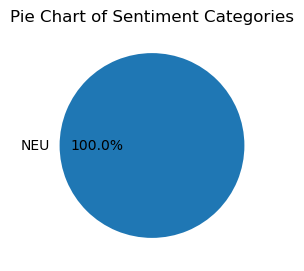

In [74]:
# Count the occurrences of each category
category_counts = sentiment_analysis_of_countries['Sentiment'].value_counts()

# Create a pie plot
plt.figure(figsize=(3, 3))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')

# Adding a title (optional)
plt.title('Pie Chart of Sentiment Categories')

# Show the plot
plt.show()

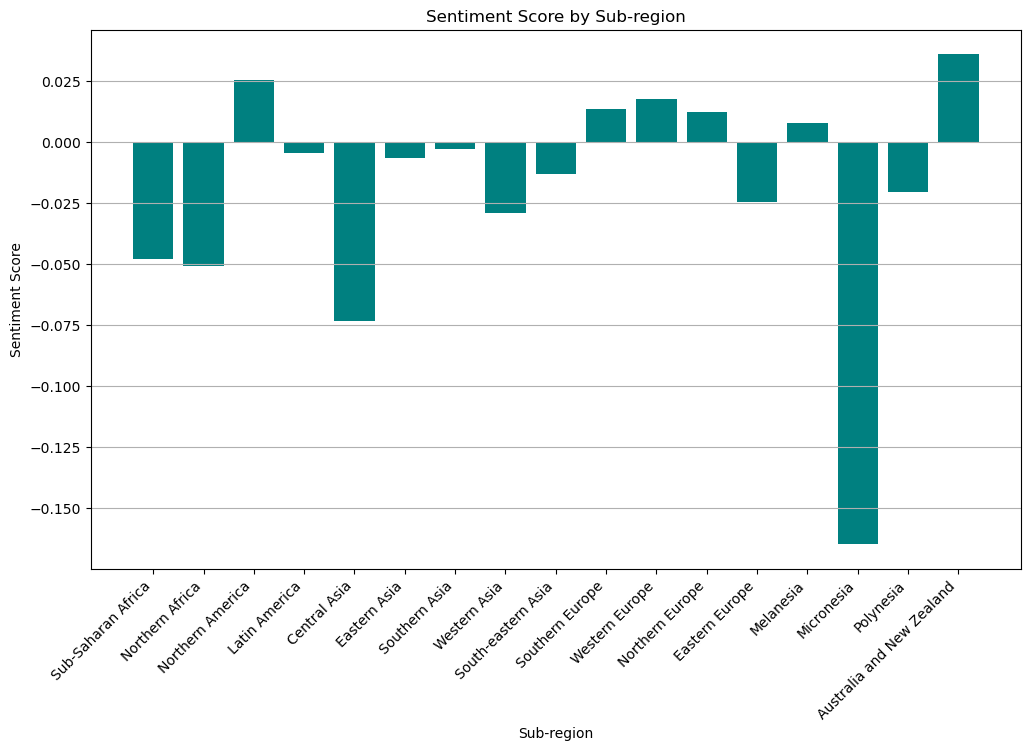

In [78]:
# Sentiment Analysis
sentiment_analysis_of_countries['sentiment score'] = sentiment_analysis_of_countries.copy().apply(
    lambda row: (row.POS_sum - row.NEG_sum) / (row.NEG_count + row.NEU_count + row.POS_count), axis=1)

# df_country_and_region = pd.DataFrame(list(country_to_region.items()), columns=['Country', 'Sub-region'])

sa_to_plot = (pd.merge(sentiment_analysis_of_countries, df_country_region, how='left', on='Country')[['sentiment score', 'Region']].groupby('Region').mean()).reset_index()

sa_to_plot['Last Word to sort on'] = sa_to_plot['Region'].str.split().str[-1]
sa_to_plot = sa_to_plot.sort_values(by='Last Word to sort on')
sa_to_plot.drop('Last Word to sort on', axis=1, inplace=True)

import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12, 7))
plt.bar(sa_to_plot['Region'], sa_to_plot['sentiment score'], color='teal')
plt.title('Sentiment Score by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show plot
plt.show()

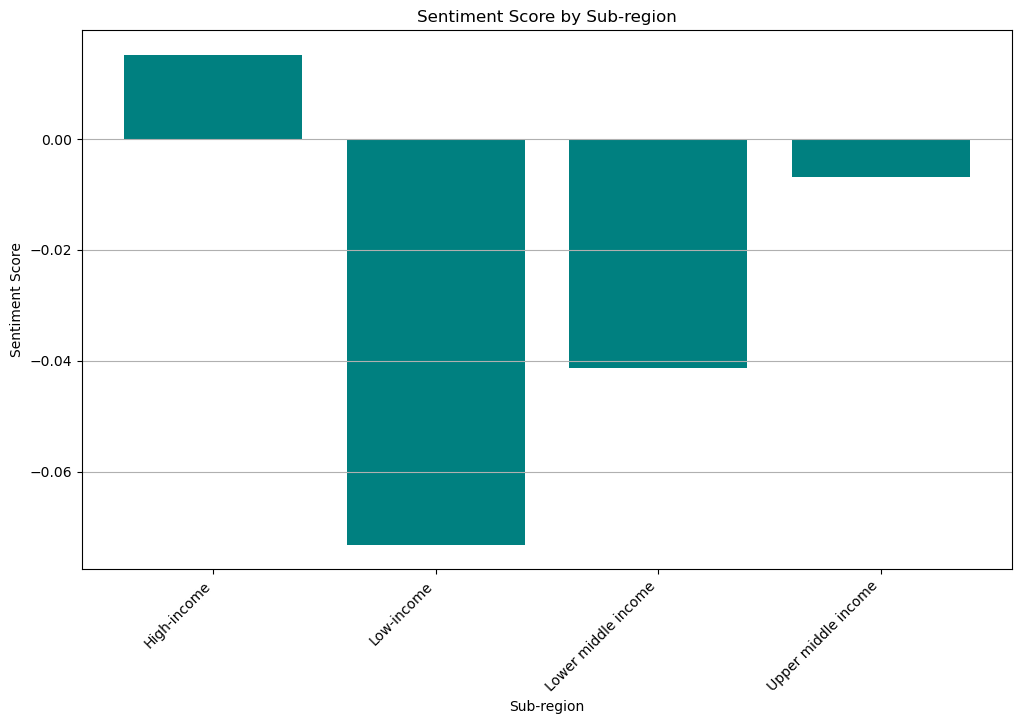

In [86]:
# Sentiment Analysis
UN_countries_by_economies.rename(columns={'Country or Area' : 'Country'}, inplace=True)
sa_to_plot = (pd.merge(sentiment_analysis_of_countries, UN_countries_by_economies, how='left', on='Country')[['sentiment score', 'Economic classification']].groupby('Economic classification').mean()).reset_index()
UN_countries_by_economies.rename(columns={'Country': 'Country or Area'}, inplace=True)

# Plot
plt.figure(figsize=(12, 7))
plt.bar(sa_to_plot['Economic classification'], sa_to_plot['sentiment score'], color='teal')
plt.title('Sentiment Score by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show plot
plt.show()

## Second section of research questions
The focus is on the pathways that were taken by the players, where the target or goal article of the game is a country.
### Finished paths and target countries

In [24]:
country_path_overview = path_overview[path_overview['target'].isin(countries)]

country_path_overview = country_path_overview.merge(df_country_region, 
                                                    left_on='target', 
                                                    right_on='article', 
                                                    how='left').drop(['article'], axis=1)

In [25]:
region_completed_count = country_path_overview[['region','completed','target']].groupby(['region','completed']).count()
region_count = country_path_overview[['region','target']].groupby(['region']).count()
# region_completed_count.set_index(['region'], inplace=True)
region_count

,target
region,
,20
Asia,5
Australia and New Zealand,40
Central Asia,96
Eastern Asia,232
Eastern Europe,274
Europe,15
Latin America and the Caribbean,602
Melanesia,27


Each continent is reasonably represented in terms of number of times it was a target of the game, this supports the fact that should be enough data for us to analysis the ratio of finished/unfinished pathways.

In [26]:
proportions = pd.DataFrame()

for region, completion in region_completed_count.index:
    proportion = region_completed_count.loc[(region, completion)] / region_count.loc[region]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    print(f"Proportion of {status} paths with {region} as target: {round(proportion.values[0]*100,4)}%")

Proportion of unfinished paths with  as target: 15.0%
Proportion of finished paths with  as target: 85.0%
Proportion of finished paths with Asia as target: 100.0%
Proportion of unfinished paths with Australia and New Zealand as target: 2.5%
Proportion of finished paths with Australia and New Zealand as target: 97.5%
Proportion of unfinished paths with Central Asia as target: 18.75%
Proportion of finished paths with Central Asia as target: 81.25%
Proportion of unfinished paths with Eastern Asia as target: 7.7586%
Proportion of finished paths with Eastern Asia as target: 92.2414%
Proportion of unfinished paths with Eastern Europe as target: 9.854%
Proportion of finished paths with Eastern Europe as target: 90.146%
Proportion of unfinished paths with Europe as target: 33.3333%
Proportion of finished paths with Europe as target: 66.6667%
Proportion of unfinished paths with Latin America and the Caribbean as target: 14.2857%
Proportion of finished paths with Latin America and the Caribbean 

Basic statistics representing the ratio of finished vs unfinished paths towards a country of a specific continent already reflects some difference between the continents. Europe and Africa have the highest finish rate in front of Asia, Oceania and Americas, interestingly Africa was almost two times less a target as Asia. Further correlation test such as the Pearson correlation test could be applied to answer the 3rd research question.

### Length of pathway analysis

In [27]:
regions_paths = country_path_overview[['region','shortest_distance','game_path']][country_path_overview['completed']==True].groupby(by=['region','shortest_distance']).mean().reset_index()

In [28]:
regions_paths_1 = regions_paths[regions_paths['shortest_distance'] == 1]
regions_paths_2 = regions_paths[regions_paths['shortest_distance'] == 2]
regions_paths_3 = regions_paths[regions_paths['shortest_distance'] == 3]
regions_paths_4 = regions_paths[regions_paths['shortest_distance'] == 4]

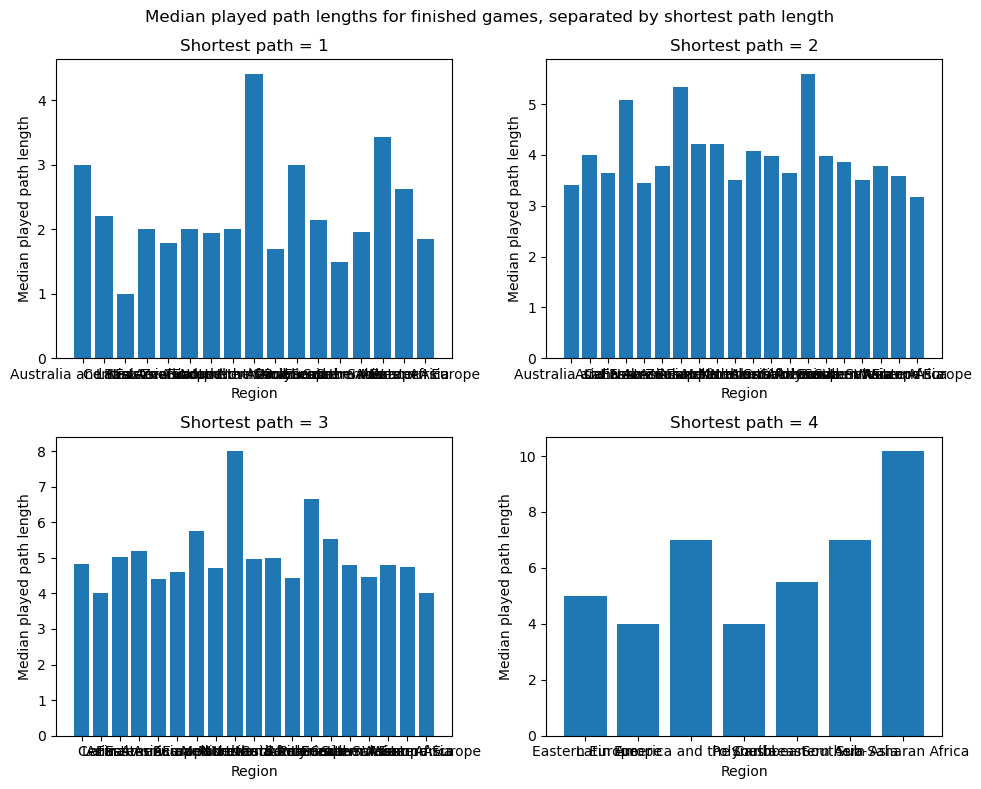

In [29]:
figs, axs = plt.subplots(2,2, figsize=(10,8))

figs.suptitle("Median played path lengths for finished games, separated by shortest path length")

axs[0,0].bar(regions_paths_1['region'], regions_paths_1['game_path'])
axs[0,0].set_title("Shortest path = 1")
axs[0,0].set_xlabel("Region")
axs[0,0].set_ylabel("Median played path length")

axs[0,1].bar(regions_paths_2['region'], regions_paths_2['game_path'])
axs[0,1].set_title("Shortest path = 2")
axs[0,1].set_xlabel("Region")
axs[0,1].set_ylabel("Median played path length")

axs[1,0].bar(regions_paths_3['region'], regions_paths_3['game_path'])
axs[1,0].set_title("Shortest path = 3")
axs[1,0].set_xlabel("Region")
axs[1,0].set_ylabel("Median played path length")

axs[1,1].bar(regions_paths_4['region'], regions_paths_4['game_path'])
axs[1,1].set_title("Shortest path = 4")
axs[1,1].set_xlabel("Region")
axs[1,1].set_ylabel("Median played path length")

plt.tight_layout()
plt.show()

## Third section of research questions
The focus for the last two research questions is on trying to control for as many confounders as possible that might influence country wise bias.


### Sentiment analysis

#### Example of sentiment analysis


# Analysis of Bias in the Wikispeedia Dataset and Player Pathways

### Metrics for Comparison
We calculate various metrics (referred to as 'Vs') for each country (denoted as 'C') in the Wikispeedia dataset:

* Length of the Wikipedia article for country C
* Sentiment analysis of the Wikipedia article for country C
* Number of hyperlinks in other articles pointing to the article about country C
* Number of hyperlinks in the article about country C pointing to other articles
* Proportion of completed and uncompleted pathways where country C was the target
* Length of pathways targeting country C
* Frequency of article C's involvement in pathways where it was neither the start nor the target

### Analyzing Vs to Detect Representation Bias
Given the extensive scope of countries (over 200), we categorize them by region/continent and economic development, utilizing the UN datasets mentioned in the README.

Correlations between the above metrics for country C and its regional or economic attributes do not inherently indicate causality or bias. To assess whether the Wikispeedia dataset (encompassing hyperlink structure and article content) exhibits bias, we need to control for potential confounding factors.

To achieve this, we will develop a predictive model using multiple linear regression that accounts for confounders such as population size, economic strength, and whether English is an official language in country C (considering the use of the English Wikipedia). By comparing the model's predicted values against the actual Vs, we can determine the presence and extent of representation bias.

### Assessing Player Bias
After evaluating representation bias in the Wikispeedia framework, we will reexamine the pathways chosen by players. This step aims to discern whether players merely reflect the dataset's bias or introduce additional biases. We will adopt a similar methodology as above for this analysis.

In conclusion, through the application of Natural Language Processing for sentiment analysis and comprehensive statistical controls, our objective is to uncover any latent biases in article representation and player interactions within the Wikispeedia dataset.